In [2]:

import numpy as np
import pandas

import skimage.data
import skimage.transform
from skimage import data, io, filters

In [2]:
import math

width = 128
height = 92
# Import Labels
labels = []
imagePaths = []
lastTrackingAngle = 0
lastSpeed = 0
for i in range(20,26):
    fname = "G:/CarDataNew/AccelerationData/capture"+str(i)+"/accelClass.txt"
    base = "G:/CarDataNew/AccelerationData/capture"+str(i) + "/"
    with open(fname) as f:
        content = f.readlines()
        for line in content:
            line = line.split(",")
            speedString = (line[1].split(" "))[2]
            speed = float(speedString)
            trackingAngleString = (line[8].split(" "))[2]
            trackingAngle = float(trackingAngleString)
            deltaTrackingAngle = trackingAngle - lastTrackingAngle
            deltaSpeed = speed - lastSpeed
            lastTrackingAngle = trackingAngle
            lastSpeed = speed
            filePath = (line[10])
            if speed > 30 and abs(deltaTrackingAngle) > 0.5 and abs(deltaTrackingAngle) < 7:
                labels.append(deltaTrackingAngle)
                if(deltaTrackingAngle>0):
                    deltaTrackingAngle = 1
                else:
                    deltaTrackingAngle = -1
                #labels.append(speed)
                #labels.append(deltaTrackingAngle)
                #print speed
                #print trackingAngle
                picturePath = base+filePath
                #print picturePath
                imagePaths.append(picturePath)

trainingIndex = int(len(imagePaths)/1.4)

In [5]:
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters

from skimage.color import rgb2gray
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters
import operator
from operator import sub


@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)

def as_gray(image_filter, image, *args, **kwargs):
    gray_image = rgb2gray(image)
    return image_filter(gray_image, *args, **kwargs)

@adapt_rgb(as_gray)
def sobel_gray(image):
    return image



images = np.zeros((len(imagePaths),height,width,3))
print(images.shape)
threadCount = 20
import threading

def worker(loadPath, loadPath2, imageIndex):
    """thread worker function"""
    image = skimage.data.imread(loadPath)
    image2 = skimage.data.imread(loadPath2)
    image = skimage.transform.resize(image, (height, width), mode='reflect')
    image2 = skimage.transform.resize(image2, (height, width), mode='reflect')
    edges = sobel_gray(image)
    edges2 = sobel_gray(image2)
    edges3 = edges2-edges
    images[imageIndex] = image2
    return edges3, imageIndex

for imNum in range(0,len(imagePaths),threadCount):
    threads = []
    for i in range(threadCount):
        
        if(imNum+i >= len(imagePaths)):
            continue
        if(imNum+1==0):
            loadPath = imagePaths[mNum+i]
            loadPath2 = imagePaths[imNum+i]
        else:
            loadPath = imagePaths[imNum+i-1]
            loadPath2 = imagePaths[imNum+i]
        t = threading.Thread(target=worker, args=(loadPath,loadPath2,imNum+i))
        threads.append(t)
        t.start()

(1533, 92, 128, 3)


[[[ 0.29488491  0.29488491  0.29488491]
  [ 0.47749361  0.47749361  0.47749361]
  [ 0.35251492  0.34032396  0.32199488]
  ..., 
  [ 0.9372549   0.9372549   0.9372549 ]
  [ 0.9372549   0.9372549   0.9372549 ]
  [ 0.9372549   0.9372549   0.9372549 ]]

 [[ 0.38303495  0.38567775  0.37510656]
  [ 0.36615516  0.36231884  0.32693947]
  [ 0.35021313  0.34117647  0.32813299]
  ..., 
  [ 0.9372549   0.9372549   0.9372549 ]
  [ 0.9372549   0.9372549   0.9372549 ]
  [ 0.9372549   0.9372549   0.9372549 ]]

 [[ 0.41636829  0.41636829  0.41636829]
  [ 0.30980392  0.31372549  0.29019608]
  [ 0.3455243   0.33870418  0.31943734]
  ..., 
  [ 0.9372549   0.9372549   0.9372549 ]
  [ 0.9372549   0.9372549   0.9372549 ]
  [ 0.9372549   0.9372549   0.9372549 ]]

 ..., 
 [[ 0.25882353  0.26666667  0.23137255]
  [ 0.25669224  0.26095482  0.22745098]
  [ 0.25669224  0.26453538  0.22071611]
  ..., 
  [ 0.30306905  0.27630009  0.25098039]
  [ 0.28346121  0.26777494  0.2599318 ]
  [ 0.28985507  0.28167093  0.26564

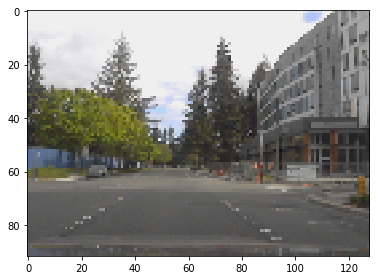

In [6]:

image = images[140]
print(images[23])
print(labels[140])
io.imshow(image)
io.show()

In [7]:

images = np.asarray(images)
images = images.reshape(len(images),width,height, 3)

In [8]:
labels = np.array(labels)
images = np.array(images)
print("labels: ", labels.shape, "\nimages: ", images.shape)

labels:  (1533,) 
images:  (1533, 128, 92, 3)


In [9]:
maxLength = trainingIndex
global currentPos
currentPos = 0
def nextTraining(batch_size):
    """ Return a batch of data. When dataset end is reached, start over.
    """
    #if self.batch_id == len(self.data):
    #    self.batch_id = 0
    #batch_data = (self.data[self.batch_id:min(self.batch_id +
    #                                          batch_size, len(self.data))])
    #batch_labels = (self.labels[self.batch_id:min(self.batch_id +
    #                                          batch_size, len(self.data))])
    #batch_seqlen = (self.seqlen[self.batch_id:min(self.batch_id +
    #                                          batch_size, len(self.data))])
    #self.batch_id = min(self.batch_id + batch_size, len(self.data))
    global currentPos
    currentPos = currentPos + batch_size
    maxPos = currentPos + batch_size
    if(maxPos>maxLength):
        currentPos = 0
        maxPos = currentPos + batch_size
    batch_data = (images[currentPos:maxPos])
    batch_labels = (labels[currentPos:maxPos])
    return batch_data, batch_labels



In [10]:
maxTestingLength = len(labels)
global currentTestingPos
global minIndex 
minIndex = trainingIndex
currentTestingPos = minIndex

def nextTesting(batch_size):
    global currentTestingPos
    global minIndex
    currentTestingPos = currentTestingPos + batch_size
    maxPos = currentTestingPos + batch_size
    if(maxPos>maxTestingLength):
        currentTestingPos = minIndex
        maxPos = currentTestingPos + batch_size
    batch_data = (images[currentTestingPos:maxPos])
    batch_labels = (labels[currentTestingPos:maxPos])
    return batch_data, batch_labels

In [11]:
x, y = nextTraining(128)
print(x.shape)
print(y)

cellInitialized = 0

(128, 128, 92, 3)
[-0.72  0.55 -1.05  2.44 -4.51  3.1  -4.16  4.71 -1.98 -2.17  0.91 -0.6
 -0.87  0.75  0.93 -2.41 -2.09 -1.34  0.59 -1.59  2.29  0.77  0.92  2.46
  3.73 -5.6   0.66 -0.91  1.35  3.72 -3.62 -1.25  0.63 -2.68  3.23  0.83
  0.52 -0.86 -1.1  -0.67 -0.74  1.35 -0.63  0.63 -1.04  0.98  1.    0.8
 -0.9   0.85 -0.73  6.32  2.81  1.01 -0.63  2.52  2.59  3.1   3.12  6.7
  2.23 -0.62  0.88 -2.57 -1.59 -1.75 -2.86 -4.49 -3.06 -2.81 -3.57 -3.49
 -2.29 -1.52  0.63  0.93  5.88  3.7   3.05  4.08  6.49  6.04  4.51  0.89
  0.82 -0.68 -0.9   0.83 -1.44  2.17  3.5   5.12  5.83  3.86  5.9   2.81
 -0.74  0.79  2.74 -0.99  2.33  3.18 -2.45  1.26 -1.35 -2.19 -1.9  -0.85
 -1.43 -1.21 -1.01 -0.85 -2.25 -0.59 -1.51 -2.88 -1.57 -0.85 -2.02 -1.27
 -0.95 -1.39 -0.94 -0.71 -0.6  -1.62 -1.14 -1.12]


In [13]:
'''
A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn

'''
To classify images using a recurrent neural network, we consider every image
row as a sequence of pixels. Because MNIST image shape is 28*28px, we will then
handle 28 sequences of 28 steps for every sample.
'''
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer()) 
# Parameters
learning_rate = 0.0001
training_epochs = 15
batch_size = 64
display_step = 10

# Network Parameters
n_input = width*height*3 # MNIST data input (img shape: 28*28)
n_classes = 1 # MNIST total classes (0-9 digits)

x = tf.placeholder(tf.float32, shape=[None, n_input])
y = tf.placeholder(tf.float32, shape=[None, n_classes])
W = tf.Variable(tf.zeros([n_input,n_classes]))
b = tf.Variable(tf.zeros([n_classes]))


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

W_conv1 = weight_variable([9, 9, 3, 34])
b_conv1 = bias_variable([34])

x_image = tf.reshape(x, [-1,92,128,3])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 34, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([32 * 23 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1,32 * 23 *64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 1])
b_fc2 = bias_variable([1])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

pred = y_conv

accuracyFloor = tf.constant(0.1, tf.float32)

# Define loss and optimizer
loss = tf.maximum(tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(pred, y)))),accuracyFloor)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Evaluate model
#correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(pred, y))))

# Initializing the variables
sess.run(tf.global_variables_initializer())



ResourceExhaustedError: OOM when allocating tensor with shape[35328,1]
	 [[Node: Variable/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable, zeros)]]

Caused by op 'Variable/Assign', defined at:
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-80d6f18e58d4>", line 34, in <module>
    W = tf.Variable(tf.zeros([n_input,n_classes]))
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\variables.py", line 197, in __init__
    expected_shape=expected_shape)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\variables.py", line 306, in _init_from_args
    validate_shape=validate_shape).op
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\state_ops.py", line 270, in assign
    validate_shape=validate_shape)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "c:\users\ndmmc\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[35328,1]
	 [[Node: Variable/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable, zeros)]]


In [12]:
training_iters = 2400000
step =0
display_step = 150
# Keep training until reach max iterations
while step * batch_size < training_iters:
    batch_x, batch_y = nextTraining(batch_size)
    # Reshape data to get 28 seq of 28 elements
    batch_x = batch_x.reshape((batch_size, n_input))
    batch_y = batch_y.reshape((batch_size, 1))
    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
    if step % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        # Calculate batch loss
        cost = sess.run(loss, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(cost) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
#Speed accuracy

step = 1
totalMAE = 0
correctDirectionCount = 0
totalCount = 0
threshold = 12
# Calculate accuracy for 128 mnist test images
while step * batch_size < (len(images)-trainingIndex):
    test_data, test_label = nextTesting(batch_size)
    test_data = test_data.reshape((batch_size, n_input))
    test_label = test_label.reshape((batch_size, 1))
    predAccuracy = sess.run(accuracy, feed_dict={x: test_data, y: test_label, keep_prob: 0.5})
    results = sess.run(pred, feed_dict={x: test_data, keep_prob: 0.5})
    #print(results)
    #print(test_label)
    for i in range(0,len(results)):
        element = results[i] * test_label[i]
        if(abs(test_label[i])>75):
            continue
        totalCount+=1
        print("Actual:", test_label[i],"Guess:",results[i],"Delta",element)
        if element > 0:
            correctDirectionCount+=1
    totalMAE += predAccuracy
    print("Testing Accuracy:", predAccuracy)
    step+=1
print("Total MAE: ", (totalMAE/(step-1)))
print("Turn percentage", (totalCount/((step-1) * batch_size)))
print ("Correct Speed within threshold percentage ",(correctDirectionCount/totalCount))